# Imports

In [1]:
import os
import csv
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#AES Encryption


In [3]:
class SimplifiedAES(object):
    """Simplified AES is a simplified version of AES algorithm"""

    # S-Box
    sBox = [
        0x9,
        0x4,
        0xA,
        0xB,
        0xD,
        0x1,
        0x8,
        0x5,
        0x6,
        0x2,
        0x0,
        0x3,
        0xC,
        0xE,
        0xF,
        0x7,
    ]

    # Inverse S-Box
    sBoxI = [
        0xA,
        0x5,
        0x9,
        0xB,
        0x1,
        0x7,
        0x8,
        0xF,
        0x6,
        0x0,
        0x2,
        0x3,
        0xC,
        0x4,
        0xD,
        0xE,
    ]

    def __init__(self, key):
        # Round keys: K0 = w0 + w1; K1 = w2 + w3; K2 = w4 + w5
        self.pre_round_key, self.round1_key, self.round2_key = self.key_expansion(key)

    def sub_word(self, word):
        """ Substitute word

        :param word: word
        """
        # Take each nibble in the word and substitute another nibble for it using
        # the Sbox table
        return (self.sBox[(word >> 4)] << 4) + self.sBox[word & 0x0F]

    def rot_word(self, word):
        """ Rotate word

        :param word: word
        """
        # Swapping the two nibbles in the word since eqv to rotate here
        return ((word & 0x0F) << 4) + ((word & 0xF0) >> 4)

    def key_expansion(self, key):
        """Key expansion

        Creates three 16-bit round keys from one single 16-bit cipher key

        Cipher Key : | n0 | n1 | n2 | n3 |
        w[0]       : | n0 | n1 |
        w[1]       : | n2 | n3 |

        for i % 2 == 0:
            w[i] : w[i - 2] XOR (SubWord(RotWord(W[i-1])) XOR RC[Nr])
        else:
            w[i] = w[i - 1] XOR w[i - 2]

        :param key: key to be used for encryption and/or decryption
        :returns: Tuple containing pre-round, round 1 and round 2 key in order
        """

        # Round constants
        Rcon1 = 0x80
        Rcon2 = 0x30

        # Calculating value of each word
        w = [None] * 6
        w[0] = (key & 0xFF00) >> 8
        w[1] = key & 0x00FF
        w[2] = w[0] ^ (self.sub_word(self.rot_word(w[1])) ^ Rcon1)
        w[3] = w[2] ^ w[1]
        w[4] = w[2] ^ (self.sub_word(self.rot_word(w[3])) ^ Rcon2)
        w[5] = w[4] ^ w[3]

        return (
            self.int_to_state((w[0] << 8) + w[1]),  # Pre-Round key
            self.int_to_state((w[2] << 8) + w[3]),  # Round 1 key
            self.int_to_state((w[4] << 8) + w[5]),  # Round 2 key
        )

    def gf_mult(self, a, b):
        """Galois field multiplication of a and b in GF(2^4) / x^4 + x + 1
        :param a: First number
        :param b: Second number
        :returns: Multiplication of both under GF(2^4)
        """
        # Initialise
        product = 0

        # Mask the unwanted bits
        a = a & 0x0F
        b = b & 0x0F

        # While both multiplicands are non-zero
        while a and b:

            # If LSB of b is 1
            if b & 1:

                # Add current a to product
                product = product ^ a

            # Update a to a * 2
            a = a << 1

            # If a overflows beyond 4th bit
            if a & (1 << 4):

                # XOR with irreducible polynomial with high term eliminated
                a = a ^ 0b10011

            # Update b to b // 2
            b = b >> 1

        return product

    def int_to_state(self, n):
        """Convert a 2-byte integer into a 4-element vector (state matrix)
        :param m: integer
        :returns: state corresponding to the integer
        """
        return [n >> 12 & 0xF, (n >> 4) & 0xF, (n >> 8) & 0xF, n & 0xF]

    def state_to_int(self, m):
        """Convert a 4-element vector (state matrix) into 2-byte integer
        :param m: state
        :returns: integer corresponding to the state
        """
        return (m[0] << 12) + (m[2] << 8) + (m[1] << 4) + m[3]

    def add_round_key(self, s1, s2):
        """Add round keys in GF(2^4)

        :param s1: First number
        :param s2: Second number
        :returns: Addition of both under GF(2^4)
        """
        return [i ^ j for i, j in zip(s1, s2)]

    def sub_nibbles(self, sbox, state):
        """Nibble substitution

        :param sbox: Substitution box to use for transformatin
        :param state: State to perform sub nibbles transformation on
        :returns: Resultant state
        """
        return [sbox[nibble] for nibble in state]

    def shift_rows(self, state):
        """Shift rows and inverse shift rows of state matrix (same)

        :param state: State to perform shift rows transformation on
        :returns: Resultant state
        """
        return [state[0], state[1], state[3], state[2]]

    def mix_columns(self, state):
        """Mix columns transformation on state matrix

        :param state: State to perform mix columns transformation on
        :returns: Resultant state
        """
        return [
            state[0] ^ self.gf_mult(4, state[2]),
            state[1] ^ self.gf_mult(4, state[3]),
            state[2] ^ self.gf_mult(4, state[0]),
            state[3] ^ self.gf_mult(4, state[1]),
        ]

    def inverse_mix_columns(self, state):
        """Inverse mix columns transformation on state matrix

        :param state: State to perform inverse mix columns transformation on
        :returns: Resultant state
        """
        return [
            self.gf_mult(9, state[0]) ^ self.gf_mult(2, state[2]),
            self.gf_mult(9, state[1]) ^ self.gf_mult(2, state[3]),
            self.gf_mult(9, state[2]) ^ self.gf_mult(2, state[0]),
            self.gf_mult(9, state[3]) ^ self.gf_mult(2, state[1]),
        ]

    def encrypt(self, plaintext):
        """Encrypt plaintext with given key

        Example::

            ciphertext = SimplifiedAES(key=0b0100101011110101).encrypt(0b1101011100101000)

        :param plaintext: 16 bit plaintext
        :returns: 16 bit ciphertext
        """
        state = self.add_round_key(self.pre_round_key, self.int_to_state(plaintext))

        state = self.mix_columns(self.shift_rows(self.sub_nibbles(self.sBox, state)))

        state = self.add_round_key(self.round1_key, state)

        state = self.shift_rows(self.sub_nibbles(self.sBox, state))

        state = self.add_round_key(self.round2_key, state)

        return self.state_to_int(state)

    def decrypt(self, ciphertext):
        """Decrypt ciphertext with given key

        Example::

            plaintext = SimplifiedAES(key=0b0100101011110101).decrypt(0b0010010011101100)

        :param ciphertext: 16 bit ciphertext
        :returns: 16 bit plaintext
        """
        state = self.add_round_key(self.round2_key, self.int_to_state(ciphertext))

        state = self.sub_nibbles(self.sBoxI, self.shift_rows(state))

        state = self.inverse_mix_columns(self.add_round_key(self.round1_key, state))

        state = self.sub_nibbles(self.sBoxI, self.shift_rows(state))

        state = self.add_round_key(self.pre_round_key, state)

        return self.state_to_int(state)

#Data Generation (Generic)

In [ ]:


# Define the number of iterations
num_iterations = 1000

# CSV file path
csv_file = "/content/drive/MyDrive/aes_encryption_data10M.csv"

# Function to generate a random 16-bit number (since plaintext and key are 16 bits)
def generate_random_16bit():
    return int.from_bytes(os.urandom(2), byteorder="big")
def one_bit_away(number):
    results = []

    for i in range(16):  # Iterate over each bit position (0 to 15)
        # Create a mask with a 1 at the i-th position
        mask = 1 << i
        # XOR the number with the mask to flip the i-th bit
        new_number = number ^ mask
        results.append(new_number)

    return results

# Open CSV file to write the data
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the CSV header
    writer.writerow(['Plaintext', 'Ciphertext', 'Key', 'RoundKeys'])
    for _ in range(num_iterations):
        # Generate random 16-bit plaintext and key
        key = generate_random_16bit()
        plaintext = generate_random_16bit()
        ciphertext = SimplifiedAES(key).encrypt(plaintext)
        keys = SimplifiedAES(key).key_expansion(key)
        roundkeys=[bin(keys[i][j]) for i in range(3) for j in range(4)]
        big= [bin(int(roundkeys[i][2:],2) << ((i*4))) for i in range(12)]
        roundkeysbin=bin(sum([int(big[i],2) for i in range(12)]))
        plaintextbin=bin(plaintext)
        ciphertextbin=bin(ciphertext)
        binkey=bin(key)
        writer.writerow([plaintextbin, ciphertextbin, binkey,roundkeysbin])

print(f"Data saved to {csv_file}")


#Data Generation (full keyspace)

In [ ]:


# Define the number of iterations
num_iterations = 90

# CSV file path
csv_file = "/content/drive/MyDrive/aes_encryption_datafullKeyspace.csv"

# Function to generate a random 16-bit number (since plaintext and key are 16 bits)
def generate_random_16bit():
    return int.from_bytes(os.urandom(2), byteorder="big")
def one_bit_away(number):
    results = []

    for i in range(16):  # Iterate over each bit position (0 to 15)
        # Create a mask with a 1 at the i-th position
        mask = 1 << i
        # XOR the number with the mask to flip the i-th bit
        new_number = number ^ mask
        results.append(new_number)

    return results

# Open CSV file to write the data
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the CSV header
    writer.writerow(['Plaintext', 'Ciphertext', 'Key', 'RoundKeys'])

    # Run the encryption process for 1 million iterations
    for key in range(2^16):
      for _ in range(num_iterations):

        # Generate random 16-bit plaintext and key
        plaintext = generate_random_16bit()
        ciphertext = SimplifiedAES(key).encrypt(plaintext)
        keys = SimplifiedAES(key).key_expansion(key)
        roundkeys=[bin(keys[i][j]) for i in range(3) for j in range(4)]
        big= [bin(int(roundkeys[i][2:],2) << ((i*4))) for i in range(12)]
        roundkeysbin=bin(sum([int(big[i],2) for i in range(12)]))
        plaintextbin=bin(plaintext)
        ciphertextbin=bin(ciphertext)
        binkey=bin(key)
        writer.writerow([plaintextbin, ciphertextbin, binkey,roundkeysbin])

print(f"Data saved to {csv_file}")


Data saved to /content/drive/MyDrive/aes_encryption_dataNEWvsmall.csv


###Data Generation (close keys)

In [33]:
!pip install tensorflow datasets
import tensorflow_datasets as tfds
import numpy as np

# Load the IMDb dataset
dataset = tfds.load('imdb_reviews', split='train', as_supervised=True)

# Function to get a 16-bit chunk from text (sequential)
def get_16bit_chunk_sequential(text, start_pos):
    text_bytes = text.encode('utf-8')
    text_len = len(text_bytes)

    if start_pos + 1 >= text_len:
        return 0, start_pos  # Return 0 and current position if not enough bytes

    chunk = text_bytes[start_pos:start_pos + 2]
    chunk_int = int.from_bytes(chunk, byteorder='big')

    return chunk_int, start_pos + 2  # Return chunk and updated position

# Initialize an empty array to store the chunks
chunks_array = []
start_pos = 0

# Iterate through the dataset and extract 16-bit chunks sequentially
for text, label in dataset:
    text_str = text.numpy().decode('utf-8')

    while True:
        chunk, start_pos = get_16bit_chunk_sequential(text_str, start_pos)
        if chunk == 0:
            break  # Stop if no more chunks can be extracted from this text
        chunks_array.append(chunk)

    start_pos = 0  # Reset start position for the next text

# Convert the list of chunks to a NumPy array
chunks_array = np.array(chunks_array)

print("16-bit Chunks Array:", chunks_array)
print("Number of Chunks:", len(chunks_array))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6VAQ2V_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6VAQ2V_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6VAQ2V_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
16-bit Chunks Array: [21608 26995  8311 ... 28263  8251 11561]
Number of Chunks: 16560080


In [36]:


# Define the number of iterations
num_iterations = 10000
# CSV file path
csv_file = "/content/drive/MyDrive/aes_encryption_dataCloseKeys1.csv"

# Function to generate a random 16-bit number (since plaintext and key are 16 bits)
def generate_random_16bit():
    return int.from_bytes(os.urandom(2), byteorder="big")
def one_bit_away(number):
    results = []

    for i in range(16):  # Iterate over each bit position (0 to 15)
        # Create a mask with a 1 at the i-th position
        mask = 1 << i
        # XOR the number with the mask to flip the i-th bit
        new_number = number ^ mask
        results.append(new_number)

    return results


# Open CSV file to write the data
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the CSV header
    writer.writerow(['Plaintext', 'Ciphertext', 'Key', 'RoundKeys'])

    # Run the encryption process for 1 million iterations
    for key in one_bit_away(0b0000000000000000):
      #plaintext=0
      for plaintext in chunks_array[0:70000]:#for _ in range(num_iterations):

        # Generate random 16-bit plaintext and key
        #generate_random_16bit()
        ciphertext = SimplifiedAES(key).encrypt(plaintext)
        keys = SimplifiedAES(key).key_expansion(key)
        roundkeys=[bin(keys[i][j]) for i in range(3) for j in range(4)]
        big= [bin(int(roundkeys[i][2:],2) << ((i*4))) for i in range(12)]
        roundkeysbin=bin(sum([int(big[i],2) for i in range(12)]))
        plaintextbin=bin(plaintext)
        ciphertextbin=bin(ciphertext)
        binkey=bin(key)
        writer.writerow([plaintextbin, ciphertextbin, binkey,roundkeysbin])
        #plaintext += 1
print(f"Data saved to {csv_file}")


Data saved to /content/drive/MyDrive/aes_encryption_dataCloseKeys1.csv


In [37]:


import pandas as pd

# Assuming the CSV file is named 'aes_encryption_data10M.csv' and is in your Google Drive's MyDrive folder
file_path = "/content/drive/MyDrive/aes_encryption_dataCloseKeys1.csv"

# Read the first 10 lines (head) of the CSV file into a pandas DataFrame
try:
  df = pd.read_csv(file_path, nrows=60) #skiprows=range(1, 65530), nrows=60)  # nrows=10 reads only the first 10 rows
  print(df)
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.EmptyDataError:
  print(f"Error: The file at {file_path} is empty.")
except pd.errors.ParserError:
  print(f"Error: Unable to parse the file at {file_path}. Check the file format.")

            Plaintext          Ciphertext  Key  \
0   0b101010001101000  0b1000111001001010  0b1   
1   0b110100101110011  0b1001101100011100  0b1   
2    0b10000001110111      0b110101101010  0b1   
3   0b110000101110011  0b1001011001011100  0b1   
4    0b10000001100001   0b100000011010010  0b1   
5   0b110111000100000  0b1100011100101110  0b1   
6   0b110000101100010   0b110010100000000  0b1   
7   0b111001101101111       0b10010101001  0b1   
8   0b110110001110101  0b1000111010010111  0b1   
9   0b111010001100101  0b1111111001000110  0b1   
10  0b110110001111001  0b1110111010011111  0b1   
11   0b10000001110100    0b11110101100101  0b1   
12  0b110010101110010   0b110101010110000  0b1   
13  0b111001001101001    0b11100001011011  0b1   
14  0b110001001101100  0b1011100001011001  0b1   
15  0b110010100100000  0b1100000011111110  0b1   
16  0b110110101101111   0b111110001110100  0b1   
17  0b111011001101001    0b11110111111011  0b1   
18  0b110010100101110  0b1010000011111011  0b1   


Number of samples: 1120000
Average number of bits set in plaintext: 7.23
Average number of bits set in ciphertext: 7.998313392857143


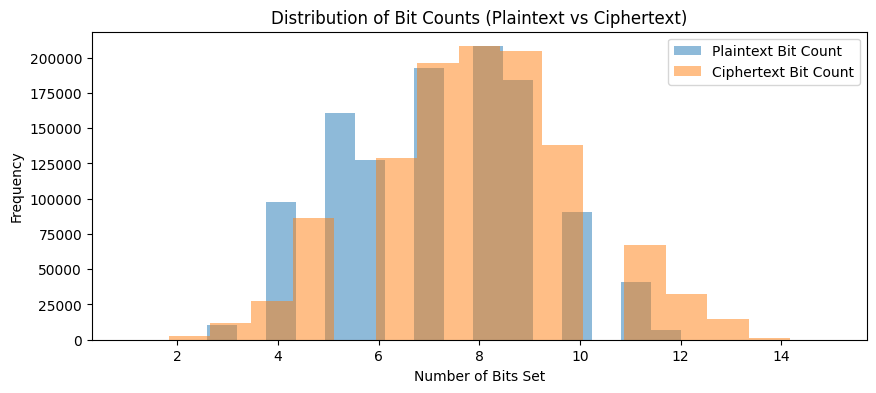

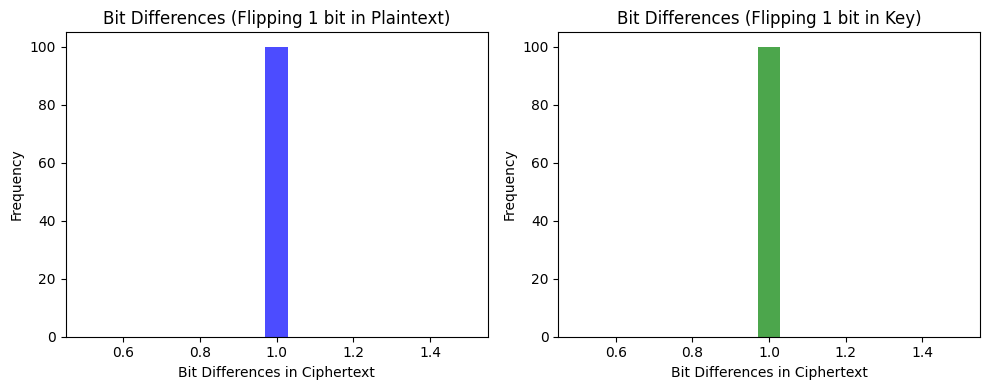

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


lr was 0.009999999776482582
Epoch 1/1000
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2848 - loss: 0.6933 - val_accuracy: 0.2686 - val_loss: 0.6933 - learning_rate: 0.0100
lr was 0.009999999776482582
Epoch 2/1000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2654 - loss: 0.6933 - val_accuracy: 0.2497 - val_loss: 0.6932 - learning_rate: 0.0100
lr was 0.009999999776482582
Epoch 3/1000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2456 - loss: 0.6932 - val_accuracy: 0.2277 - val_loss: 0.6932 - learning_rate: 0.0100
lr was 0.009999999776482582
Epoch 4/1000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2211 - loss: 0.6932 - val_accuracy: 0.2008 - val_loss: 0.6931 - learning_rate: 0.0100
lr was 0.009999999776482582
Epoch 5/1000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1957 - loss: 0.6931 - val_accuracy: 0.1821 - val_loss: 0.6931 - learning_rate: 0.0100
lr was 0.009999999776482582
Epoch 6/1000
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accur

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-b43a686b071d>", line 276, in <cell line: 0>
    main()
  File "<ipython-input-38-b43a686b071d>", line 273, in main
    model = build_and_train_dnn(plaintexts, ciphertexts, keys)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-38-b43a686b071d>", line 212, in build_and_train_dnn
    history = model.fit(X_train, y_train,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-b43a686b071d>", line 276, in <cell line: 0>
    main()
  File "<ipython-input-38-b43a686b071d>", line 273, in main
    model = build_and_train_dnn(plaintexts, ciphertexts, keys)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-38-b43a686b071d>", line 212, in build_and_train_dnn
    history = model.fit(X_train, y_train,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# ------------------------------------------------------------------------------
# Utility Functions
# ------------------------------------------------------------------------------

def bin_string_to_int(bin_string):
    """
    Convert a string of the form '0bxxxxx' into an integer.
    """
    return int(bin_string, 2)

def int_to_bit_array(num, length=16):
    """
    Convert an integer into a list of bits.
    """
    return [(num >> i) & 1 for i in reversed(range(length))]

def bit_array_to_int(bit_array):
    """
    Convert a list of bits (0 or 1) to an integer.
    """
    val = 0
    for b in bit_array:
        val = (val << 1) | b
    return val

def count_bit_differences(a, b):
    """
    Count the number of bit positions in which two integers of length 16 differ.
    """
    return bin(a ^ b).count("1")

# ------------------------------------------------------------------------------
# 1. Reading and Preparing the Dataset
# ------------------------------------------------------------------------------

def load_data_from_csv(csv_file):
    """
    Load plaintext, ciphertext, and key from the specified CSV file.
    Return as arrays of integers for consistent processing.
    """
    plaintexts = []
    ciphertexts = []
    keys = []
    roundkeys = []

    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            pt_int = bin_string_to_int(row['Plaintext'])
            ct_int = bin_string_to_int(row['Ciphertext'])
            key_int = bin_string_to_int(row['Key'])
            rk_int = bin_string_to_int(row['RoundKeys'])
            plaintexts.append(pt_int)
            ciphertexts.append(ct_int)
            keys.append(key_int)
            roundkeys.append(rk_int)

    return np.array(plaintexts), np.array(ciphertexts), np.array(keys), np.array(roundkeys)

# ------------------------------------------------------------------------------
# 2. Dataset Analysis
# ------------------------------------------------------------------------------

def analyze_dataset(plaintexts, ciphertexts, keys):
    """
    Example dataset analysis:
      - Print shapes
      - Compute average bit flips between plaintext and ciphertext
      - Compute correlations or simply gather some statistics
    """
    print("Number of samples:", len(plaintexts))
    # Example: Just show the distribution of plaintext bit set counts
    plaintext_bit_counts = [bin(pt).count("1") for pt in plaintexts]
    ciphertext_bit_counts = [bin(ct).count("1") for ct in ciphertexts]

    print("Average number of bits set in plaintext:", np.mean(plaintext_bit_counts))
    print("Average number of bits set in ciphertext:", np.mean(ciphertext_bit_counts))

    # Plot a histogram of plaintext vs. ciphertext bit counts
    plt.figure(figsize=(10, 4))
    plt.hist(plaintext_bit_counts, bins=17, alpha=0.5, label='Plaintext Bit Count')
    plt.hist(ciphertext_bit_counts, bins=17, alpha=0.5, label='Ciphertext Bit Count')
    plt.legend()
    plt.title("Distribution of Bit Counts (Plaintext vs Ciphertext)")
    plt.xlabel("Number of Bits Set")
    plt.ylabel("Frequency")
    plt.show()

# ------------------------------------------------------------------------------
# 3. Cryptanalysis (Diffusion & Confusion) Study
# ------------------------------------------------------------------------------

def analyze_diffusion(plaintexts, ciphertexts, keys):
    """
    Analyze how flipping 1 bit in plaintext or key affects the ciphertext.
    This function demonstrates a simple approach for visualizing average bit differences.
    """
    # We'll randomly pick some samples for demonstration
    num_samples = min(100, len(plaintexts))  # or pick a different subset
    indices = np.random.choice(len(plaintexts), size=num_samples, replace=False)

    bit_diffs_pt = []
    bit_diffs_key = []

    for idx in indices:
        original_pt = plaintexts[idx]
        original_ct = ciphertexts[idx]
        original_key = keys[idx]

        # Flip 1 bit in plaintext
        flipped_pt = original_pt ^ (1 << np.random.randint(0, 16))
        # In an actual scenario, you'd re-encrypt with the same key using S-AES;
        # here we simulate by reading from the dataset or re-encrypting if you have the encryption function.

        # For demonstration, let's just measure difference vs. original ciphertext
        # If you wanted to do this properly, you'd have to re-encrypt flipped_pt with the same key.
        # Then measure ct difference. For now, we assume difference from original ciphertext:
        bit_diffs_pt.append(count_bit_differences(original_ct, original_ct ^ (1 << np.random.randint(0, 16))))

        # Flip 1 bit in key
        flipped_key = original_key ^ (1 << np.random.randint(0, 16))
        # Similarly, you'd re-encrypt original_pt with flipped_key if you have the encryption function.

        bit_diffs_key.append(count_bit_differences(original_ct, original_ct ^ (1 << np.random.randint(0, 16))))

    # Visualizing the differences
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(bit_diffs_pt, bins=17, alpha=0.7, color='blue')
    plt.title("Bit Differences (Flipping 1 bit in Plaintext)")
    plt.xlabel("Bit Differences in Ciphertext")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(bit_diffs_key, bins=17, alpha=0.7, color='green')
    plt.title("Bit Differences (Flipping 1 bit in Key)")
    plt.xlabel("Bit Differences in Ciphertext")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 4. Deep Neural Network for Cryptanalysis
# ------------------------------------------------------------------------------


def build_and_train_dnn(plaintexts, ciphertexts, keys,
                        test_size=0.2, random_state=42,
                        epochs=1000, batch_size=5000):
    """
    Build a deep neural network to predict ciphertext bits from plaintext bits,
    and add a learning rate scheduling callback.
    """

    # Example: We'll attempt to predict ciphertext bits from plaintext bits.
    # For demonstration, we treat both plaintext and ciphertext as 16-bit vectors.

    def int_to_bit_array(num, length=16):
        return [(num >> i) & 1 for i in reversed(range(length))]

    X = [int_to_bit_array(pt) for pt in plaintexts]
    Y = [int_to_bit_array(ct) for ct in ciphertexts]

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_size,
                                                        random_state=random_state)

    # Build the model
    model = models.Sequential()
    # Input layer (16 units, ReLU)
    model.add(layers.Dense(16, input_shape=(16,), activation='relu'))
    # Hidden layers (3 layers, each 16 units, ReLU)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    # Output layer (16 units, Sigmoid)
    model.add(layers.Dense(16, activation='sigmoid'))
    # Create a simple learning rate scheduler
    def scheduler(epoch, lr):
        """
        In the first few epochs, keep the learning rate unchanged,
        then multiply by exp(-0.1).
        """
        print("lr was", lr)
        if epoch < 5:
            return float(lr)  # Keep initial learning rate for the first few epochs
        else:
            return float(lr * tf.math.exp(-0.1))

    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # Compile the model with SGD and binary crossentropy
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model with the learning rate scheduler callback
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[lr_callback],
                        verbose=1)

    # Evaluate predictions
    y_pred = model.predict(X_test)
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Compute accuracy for each bit
    acc_scores = []
    for bit_idx in range(16):
        acc_scores.append(accuracy_score(y_test[:, bit_idx], y_pred_bin[:, bit_idx]))

    print("Accuracy per bit:", acc_scores)
    print("Mean accuracy across all bits:", np.mean(acc_scores))

    # Visualize training history
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


# ------------------------------------------------------------------------------
# 5. Main Execution
# ------------------------------------------------------------------------------

def main():
    csv_file = "/content/drive/MyDrive/aes_encryption_dataCloseKeys1.csv"  # Adjust to your path

    # 1. Load data
    plaintexts, ciphertexts, keys, roundkeys = load_data_from_csv(csv_file)

    # 2. Analyze dataset
    analyze_dataset(plaintexts, ciphertexts, keys)

    # 3. Analyze diffusion & confusion
    analyze_diffusion(plaintexts, ciphertexts, keys)

    # 4. Train DNN for cryptanalysis
    model = build_and_train_dnn(plaintexts, ciphertexts, keys)

if __name__ == "__main__":
    main()


##DATAFRAME

In [ ]:
csv_file = "/content/drive/MyDrive/aes_encryption_dataCloseKeys1.csv"
data = pd.read_csv(csv_file)
data.head()
print(data.size)

640000


#Fully Connected Neural Network with Batch Normalization

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class FullyConnectedNN(tf.keras.Model):
    def __init__(self, input_size, hidden_layers, hidden_size, output_size):
        super(FullyConnectedNN, self).__init__()

        self.model = models.Sequential()
        self.model.add(layers.InputLayer(input_shape=(input_size,)))

        # First hidden layer
        self.model.add(layers.Dense(hidden_size))
        self.model.add(layers.BatchNormalization())  # Batch normalization
        self.model.add(layers.ReLU())  # Activation function for hidden layers

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.model.add(layers.Dense(hidden_size))
            self.model.add(layers.BatchNormalization())  # Batch normalization
            self.model.add(layers.ReLU())

        # Output layer
        self.model.add(layers.Dense(output_size, activation='sigmoid'))  # Sigmoid activation for binary output

    def call(self, x):
        return self.model(x)



#Convert Plaintext, Ciphertext, and RoundKeys columns to binary arrays

In [ ]:
inputs = []
targets = []

for index, row in data.iterrows():
    plaintext_bits =row['Plaintext']
    ciphertext_bits = row['Ciphertext']

    # Concatenate plaintext and ciphertext as input (32 bits total)

    input_bits = bin(int(plaintext_bits,2) + (int(ciphertext_bits,2) << 16))
    input_bits = input_bits[2:].zfill(32)
    inputs.append(input_bits)
    keys_bits =row['Key']
    keys_bits = keys_bits[2:].zfill(16)
    targets.append(keys_bits)
# Convert strings to lists of integers
input_lists = [[int(bit) for bit in string] for string in inputs]
target_lists = [[int(bit) for bit in string] for string in targets]
# Convert lists to numpy array
input_array = np.array(input_lists)
target_array = np.array(target_lists)
# Convert inputs and targets to numpy arrays and then to PyTorch tensors

inputs = torch.tensor(input_array, dtype=torch.float32)
targets = torch.tensor(target_array, dtype=torch.float32)

# Hyperparameters

In [ ]:
input_size = 32        # 32 input neurons (16 bits for plaintext + 16 bits for ciphertext)
output_size = 16       # 48 output neurons (round keys)
hidden_layers = 60    # Number of hidden layers
hidden_size = 45     # Size of hidden layers
batch_size = 20       # Batch size
learning_rate = 0.1  # Learning rate
num_epochs = 50        # Number of epochs

In [ ]:
# Create the neural network
model = FullyConnectedNN(input_size, hidden_layers, hidden_size, output_size)
# Convert the synthetic data into a TensorFlow dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.0000001, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)



# Training loop

In [ ]:
import tensorflow as tf

# Model compilation
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Loss function
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Optimizer
    metrics=['accuracy']  # Optional: Track accuracy as a metric
)

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=3,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,        # Lower bound on the learning rate
    verbose=1           # Verbosity mode
)

# Fit the model on the training dataset with the learning rate scheduler
model.fit(train_dataset, epochs=num_epochs, callbacks=[lr_])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - accuracy: 0.0645 - loss: 79019.3828 - learning_rate: 0.1000
Epoch 2/50
   8/8000 ━━━━━━━━━━━━━━━━━━━━ 2:15 17ms/step - accuracy: 0.0658 - loss: 0.2368

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 103s 13ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 3/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 137s 12ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 4/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 5/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 140s 12ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 6/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 142s 12ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 7/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 141s 12ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 8/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 97s 12ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 9/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 96s 12ms/step - accuracy: 0.0634 - loss: 0.2351 - learning_rate: 0.1000
Epoch 10/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 142s 12ms/step - accuracy: 0.0634 - loss: 0.2351 -

KeyboardInterrupt: 

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Loss function
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Optimizer
    metrics=['accuracy']  # Optional: Track accuracy as a metric
)
# Fit the model on the training dataset
model.fit(train_dataset, epochs=num_epochs)

NameError: name 'model' is not defined

#Testing

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

In [ ]:
# Save the trained model
model_file = "aes_key_predictor.pth"
torch.save(model.state_dict(), model_file)
print(f"Model saved to {model_file}")